In [38]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [39]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print('Device: ',device)

Device:  cuda:0


In [18]:
# Paths
input_path = '/kaggle/input/2024-flame-ai-challenge/dataset/'

# Load data
train_df = pd.read_csv(os.path.join(input_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_path, 'test.csv'))

In [19]:
# Function to load data
def load_dataX(idx, df, data_dir):
    csv_file = df.reset_index().to_dict(orient='list')
    dir_path = os.path.join(input_path, data_dir)
    
    id = csv_file['id'][idx]
    nt, Nx, Ny = csv_file['Nt'][idx], csv_file['Nx'][idx], csv_file['Ny'][idx]
    
    theta = np.fromfile(os.path.join(dir_path, csv_file['theta_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    ustar = np.fromfile(os.path.join(dir_path, csv_file['ustar_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    xi_f = np.fromfile(os.path.join(dir_path, csv_file['xi_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    
    uin = csv_file['u'][idx]
    alpha = csv_file['alpha'][idx]

    return theta, ustar, xi_f, uin, alpha

# Function to extract fire positions
def extract_fire_positions(xi_f):
    return [np.argmax(np.mean(xi_f[t], axis=1)) for t in range(xi_f.shape[0])]

In [20]:
# # Prepare training data
# X = []
# y = []
# y_tensor = np.zeros((len(train_df), 150, 113, 32))

for idx in range(len(train_df)):
    theta, ustar, xi_f, uin, alpha = load_dataX(idx, train_df, 'train')
    break

data = [
    [theta.shape, theta.mean(), theta.std(), theta.max(), theta.min()], 
    [ustar.shape, ustar.mean(), ustar.std(), ustar.max(), ustar.min()], 
    [xi_f.shape, xi_f.mean(), xi_f.std(), xi_f.max(), xi_f.min()]
]
df = pd.DataFrame(data, columns=['shape', 'mean', 'std', 'max', 'min'])
display(df)
#     y_tensor[idx] = xi_f
#     X.append([uin, alpha])
#     y.append(extract_fire_positions(xi_f))

# # Reshape data for training
# X = np.array(X)
# y = np.array(y)

# # Standardize the inputs
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

,shape,mean,std,max,min
0,"(150, 113, 32)",290.717255,21.381763,606.979004,260.062683
1,"(150, 113, 32)",4.819031,2.344468,23.833540,-2.923549
2,"(150, 113, 32)",0.023396,0.151158,1.000000,0.000000


Values of theta


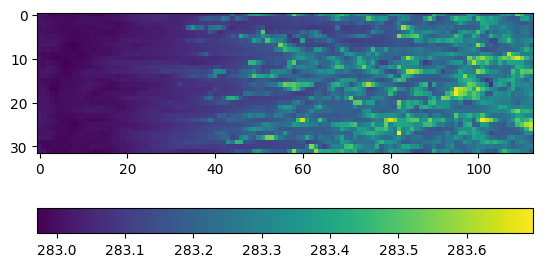

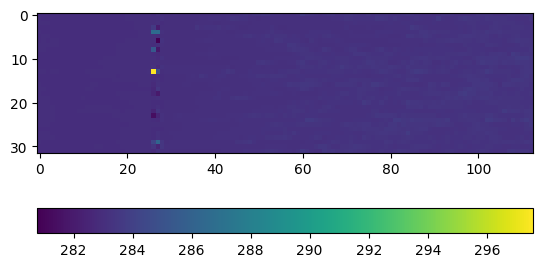

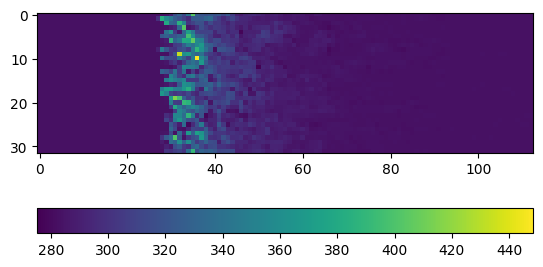

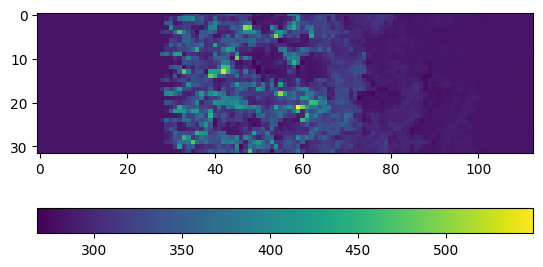

Values of ustar


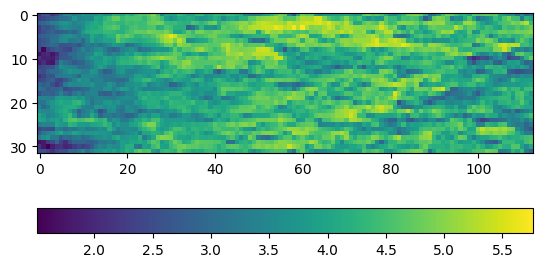

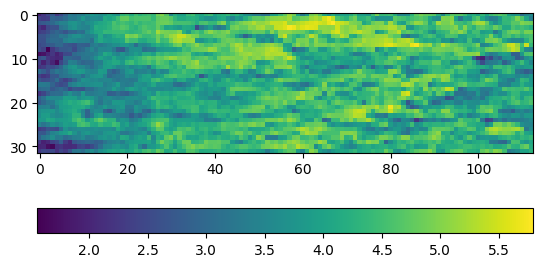

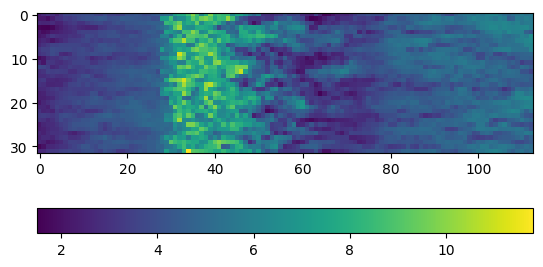

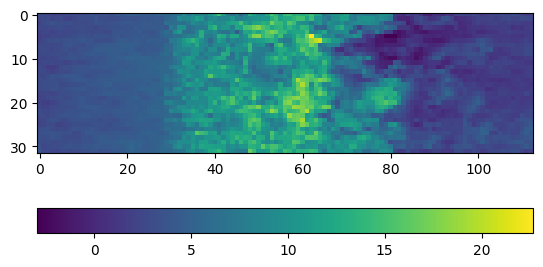

Values of xi_f


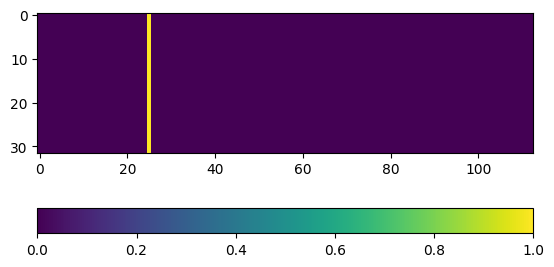

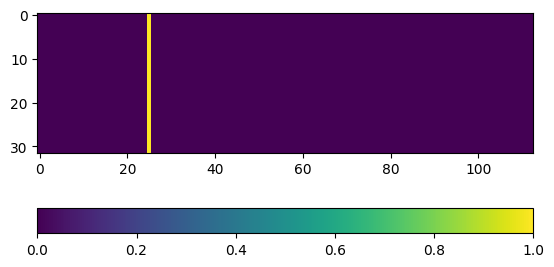

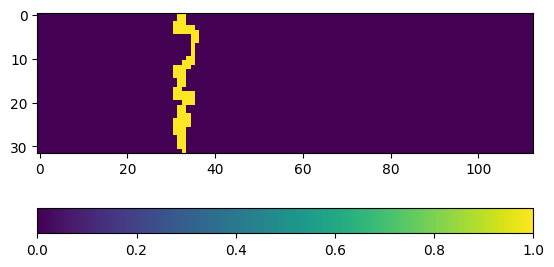

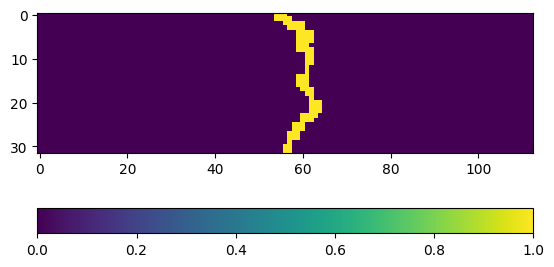

In [21]:
print("Values of theta")
plt.imshow(theta[0,:,:].T)
plt.colorbar(orientation='horizontal')
plt.show()
plt.imshow(theta[4,:,:].T)
plt.colorbar(orientation='horizontal')
plt.show()
plt.imshow(theta[75,:,:].T)
plt.colorbar(orientation='horizontal')
plt.show()
plt.imshow(theta[149,:,:].T)
plt.colorbar(orientation='horizontal')
plt.show()

print("Values of ustar")
plt.imshow(ustar[0,:,:].T)
plt.colorbar(orientation='horizontal')
plt.show()
plt.imshow(ustar[4,:,:].T)
plt.colorbar(orientation='horizontal')
plt.show()
plt.imshow(ustar[75,:,:].T)
plt.colorbar(orientation='horizontal')
plt.show()
plt.imshow(ustar[149,:,:].T)
plt.colorbar(orientation='horizontal')
plt.show()

print("Values of xi_f")
plt.imshow(xi_f[0,:,:].T)
plt.colorbar(orientation='horizontal')
plt.show()
plt.imshow(xi_f[4,:,:].T)
plt.colorbar(orientation='horizontal')
plt.show()
plt.imshow(xi_f[75,:,:].T)
plt.colorbar(orientation='horizontal')
plt.show()
plt.imshow(xi_f[149,:,:].T)
plt.colorbar(orientation='horizontal')
plt.show()

In [22]:
# Prepare training data
Datalist = []
y_tensor = np.zeros((len(train_df), 150, 113, 32))

for idx in range(len(train_df)):
    theta, ustar, xi_f, uin, alpha = load_dataX(idx, train_df, 'train')
    
    theta = torch.Tensor(theta).unsqueeze(1)
    ustar = torch.Tensor(ustar).unsqueeze(1)
    xi_f = torch.Tensor(xi_f).unsqueeze(1)
    
    uin_tensor = torch.zeros_like(xi_f) + uin
    alpha_tensor = torch.zeros_like(xi_f) + alpha
    
    TUXUA = torch.cat([theta,ustar,xi_f, uin_tensor, alpha_tensor], dim=1)
    TUXUA = TUXUA.unsqueeze(0)
    
    Datalist.append(TUXUA)
    
Data_train = torch.cat(Datalist)
print(Data_train.shape)

torch.Size([9, 150, 5, 113, 32])


In [23]:
# Prepare testing data
Datalist = []
y_tensor = np.zeros((len(test_df), 150, 113, 32))

for idx in range(len(test_df)):
    theta, ustar, xi_f, uin, alpha = load_dataX(idx, test_df, 'test')
    
    theta = torch.Tensor(theta).unsqueeze(1)
    ustar = torch.Tensor(ustar).unsqueeze(1)
    xi_f = torch.Tensor(xi_f).unsqueeze(1)
    
    uin_tensor = torch.zeros_like(xi_f) + uin
    alpha_tensor = torch.zeros_like(xi_f) + alpha
    
    TUXUA = torch.cat([theta,ustar,xi_f, uin_tensor, alpha_tensor], dim=1)
    TUXUA = TUXUA.unsqueeze(0)
    
    Datalist.append(TUXUA)
    
Data_test = torch.cat(Datalist)
print(Data_test.shape)

torch.Size([27, 5, 5, 113, 32])


In [24]:
D1 = Data_train.reshape([Data_train.shape[0]*Data_train.shape[1], Data_train.shape[2], Data_train.shape[3], Data_train.shape[4]])
D2 = Data_test.reshape([Data_test.shape[0]*Data_test.shape[1], Data_test.shape[2], Data_test.shape[3], Data_test.shape[4]])
print(D1.shape, D2.shape) 

torch.Size([1350, 5, 113, 32]) torch.Size([135, 5, 113, 32])


In [25]:
D = torch.cat([D1,D2], dim=0)
MeanX = torch.mean(D, (0,2,3)).unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
StdX = torch.std(D, (0,2,3)).unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
print(StdX.shape)   # sample, timestep, channels [theta,ustar,xi_f, uin, alpha], X, Y
print(MeanX.shape)

MeanY = torch.mean(D, (0,2,3))[:3].unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
StdY = torch.std(D, (0,2,3))[:3].unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
print(StdY.shape)   # sample, timestep, channels [theta,ustar,xi_f], X, Y
print(MeanY.shape)

torch.Size([1, 1, 5, 1, 1])
torch.Size([1, 1, 5, 1, 1])
torch.Size([1, 1, 3, 1, 1])
torch.Size([1, 1, 3, 1, 1])


In [26]:
#torch.save(Data, 'Data_tensor.pt')

In [27]:
# Create custom PyTorch dataset
class FlameDataset(Dataset):
    def __init__(self, Data, history = 1, prediction = 1):
        self.X = Data    #torch.Size([9, 150, 5, 113, 32])
        self.history = history
        self.prediction = prediction
        self.count_cases = Data.shape[0]
        self.count_timeIndices = Data.shape[1] - history - prediction + 1
        self.indices = torch.arange(self.count_cases*self.count_timeIndices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        case = idx%self.count_cases
        index = idx%self.count_timeIndices
        
        X = self.X[case,index:index + self.history,...]
        Y = self.X[case,index + self.history:index + self.history + self.prediction,:3,...]
        T = index + self.history #* torch.ones(idx.shape[0])
        return X, Y, T

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def sinusoidal_embedding(n, d, device):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d).to(device)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)]).to(device)
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1)).to(device)
    embedding[:, ::2] = torch.sin(t * wk[:, ::2]).to(device)
    embedding[:, 1::2] = torch.cos(t * wk[:, ::2]).to(device)

    return embedding

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            #nn.LeakyReLU(1., inplace=True)    # to allow negative output
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        #x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
        #                diffY // 2, diffY - diffY // 2])
        #breakpoint()
        # basically diffX diffY are placeholder without any value unless data is passed, so feature extractor fails
        #x1 = F.pad(x1, (int(str(diffX)) // 2, int(str(diffX)) - int(str(diffX)) // 2,
        #                int(str(diffY)) // 2, int(str(diffY)) - int(str(diffY)) // 2))     # get_graph_node_names was creating problem
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        #
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_filters = 4, n_channels=3, n_classes=1, bilinear=False, n_steps=1000, time_emb_dim=100, device = 'cpu'):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.device = device
        self.n_steps = n_steps

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim, device=device)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim, device)
        self.time_embed.requires_grad_(False)
         
        self.tei = self._make_te(time_emb_dim, n_channels)
        self.inc = (DoubleConv(n_channels, n_filters))
        
        self.te1 = self._make_te(time_emb_dim, n_filters)
        self.down1 = (Down(n_filters, 2*n_filters))
        
        self.te2 = self._make_te(time_emb_dim, 2*n_filters)
        self.down2 = (Down(2*n_filters, 4*n_filters))
        
        self.te3 = self._make_te(time_emb_dim, 4*n_filters)
        self.down3 = (Down(4*n_filters, 8*n_filters))
        
        factor = 2 if bilinear else 1
        
        self.te4 = self._make_te(time_emb_dim, 8*n_filters)
        self.down4 = (Down(8*n_filters, 16*n_filters // factor))
        
        self.teu1i = self._make_te(time_emb_dim, 16*n_filters)       
        self.teu1j = self._make_te(time_emb_dim, 8*n_filters)       
        self.up1 = (Up(16*n_filters, 8*n_filters // factor, bilinear))
        
        self.teu2i = self._make_te(time_emb_dim, 8*n_filters)
        self.teu2j = self._make_te(time_emb_dim, 4*n_filters)       
        self.up2 = (Up(8*n_filters, 4*n_filters // factor, bilinear))
        
        self.teu3i = self._make_te(time_emb_dim, 4*n_filters)
        self.teu3j = self._make_te(time_emb_dim, 2*n_filters)       
        self.up3 = (Up(4*n_filters, 2*n_filters // factor, bilinear))
        
        self.teu4i = self._make_te(time_emb_dim, 2*n_filters)
        self.teu4j = self._make_te(time_emb_dim, n_filters)       
        self.up4 = (Up(2*n_filters, n_filters, bilinear))
        
        self.teo = self._make_te(time_emb_dim, n_filters)
        self.outc = (OutConv(n_filters, n_classes)) # DoubleConv(n_fliters,n_classes)  # (OutConv(64, n_classes))    #1x1 conv can allow negative values in output to be mapped

    def forward(self, x, t):
        
        Xshape = x.shape
        
        x = (x - MeanX)/StdX
        
        x = x.reshape([Xshape[0], Xshape[1] * Xshape[2], Xshape[3], Xshape[4]])
        
        t = self.time_embed(t.long())  # takes in long or int tensor not float
        n = len(x)
        
        x1 = self.inc(x + self.tei(t).reshape(n, -1, 1, 1))
        x2 = self.down1(x1 + self.te1(t).reshape(n, -1, 1, 1))
        x3 = self.down2(x2 + self.te2(t).reshape(n, -1, 1, 1))
        x4 = self.down3(x3 + self.te3(t).reshape(n, -1, 1, 1))
        x5 = self.down4(x4 + self.te4(t).reshape(n, -1, 1, 1))
        x = self.up1(x5 + self.teu1i(t).reshape(n, -1, 1, 1), x4 + self.teu1j(t).reshape(n, -1, 1, 1))
        x = self.up2(x + self.teu2i(t).reshape(n, -1, 1, 1), x3 + self.teu2j(t).reshape(n, -1, 1, 1))
        x = self.up3(x + self.teu3i(t).reshape(n, -1, 1, 1), x2 + self.teu3j(t).reshape(n, -1, 1, 1))
        x = self.up4(x + self.teu4i(t).reshape(n, -1, 1, 1), x1 + self.teu4j(t).reshape(n, -1, 1, 1))
        x = self.outc(x + self.teo(t).reshape(n, -1, 1, 1))
        
        x = x.reshape([Xshape[0], 1, 3, Xshape[3], Xshape[4]])
        
        x = (x * StdY) + MeanY
        
        return x
        # logits = self.outc(x)
        # return logits
        
    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out)
        )

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [50]:
# Model parameters
batch_size = 32
learning_rate = 1e-4
num_epochs = 300
num_filters = 64
history = 2
prediction = 1

# Create dataset and dataloaders for training and test sets
train_dataset = FlameDataset(Data_train, history = history, prediction = prediction)
test_dataset = FlameDataset(Data_test, history = history, prediction = prediction)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = UNet(n_filters = num_filters, n_channels = 5 * history, n_classes = 3 * prediction, n_steps=150, time_emb_dim=100, device=device).to(device)
best_model = UNet(n_filters = num_filters, n_channels = 5 * history, n_classes = 3 * prediction, n_steps=150, time_emb_dim=100, device=device).to(device)
print('Number of model parameters = %3d'%(count_parameters(model)))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Number of model parameters = 33534179


Epoch [1/300], Train Loss: 8.066e+01, , Train Loss: 6.713e+01
Epoch [2/300], Train Loss: 5.658e+01, , Train Loss: 5.779e+01
Epoch [3/300], Train Loss: 5.306e+01, , Train Loss: 6.320e+01
Epoch [4/300], Train Loss: 5.098e+01, , Train Loss: 6.038e+01
Epoch [5/300], Train Loss: 4.914e+01, , Train Loss: 5.616e+01
Epoch [6/300], Train Loss: 4.803e+01, , Train Loss: 5.538e+01
Epoch [7/300], Train Loss: 4.611e+01, , Train Loss: 5.932e+01
Epoch [8/300], Train Loss: 4.486e+01, , Train Loss: 5.443e+01
Epoch [9/300], Train Loss: 4.469e+01, , Train Loss: 5.340e+01
Epoch [10/300], Train Loss: 4.247e+01, , Train Loss: 5.391e+01
Epoch [11/300], Train Loss: 4.079e+01, , Train Loss: 5.306e+01
Epoch [12/300], Train Loss: 3.955e+01, , Train Loss: 5.240e+01
Epoch [13/300], Train Loss: 3.707e+01, , Train Loss: 5.324e+01
Epoch [14/300], Train Loss: 3.453e+01, , Train Loss: 5.244e+01
Epoch [15/300], Train Loss: 3.254e+01, , Train Loss: 5.415e+01
Epoch [16/300], Train Loss: 3.019e+01, , Train Loss: 5.332e+01
E

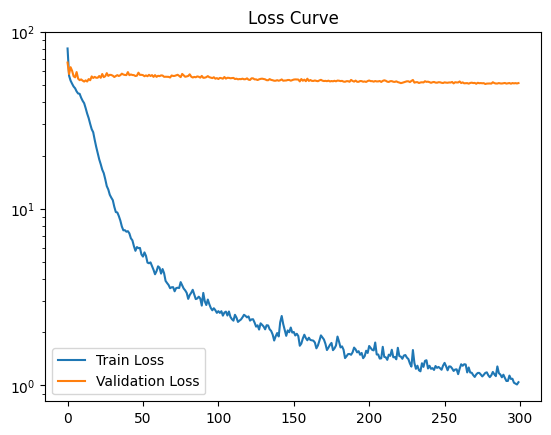

In [51]:
# Train the model
train_loss = []
validation_loss = []
best_loss = 10000
best_epoch = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    for xx,yy,tt  in train_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        tt = tt.to(device)
        optimizer.zero_grad()
        outputs = model(xx, tt*0.)
        loss = criterion(outputs, yy)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    for xx,yy,tt  in test_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        tt = tt.to(device)
        with torch.no_grad():
            outputs = model(xx, tt*0.)
        
            val_loss = criterion(outputs, yy)
        running_val_loss += val_loss.item()
    
    trn_loss = running_loss/len(train_loader)
    val_loss = running_val_loss/len(test_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {trn_loss:.3e}, , Train Loss: {val_loss:.3e}")
    
    train_loss.append(trn_loss)
    validation_loss.append(val_loss)
    
    if val_loss <= best_loss:
        best_model.load_state_dict(model.state_dict())
        torch.save(best_model, 'best_model.pth')
        best_epoch = epoch

print('best epoch: ', best_epoch + 1)

plt.plot(train_loss, label="Train Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend()
plt.yscale("log")
plt.title("Loss Curve")
plt.show()

Test MSE: 51.3924
sample:  1


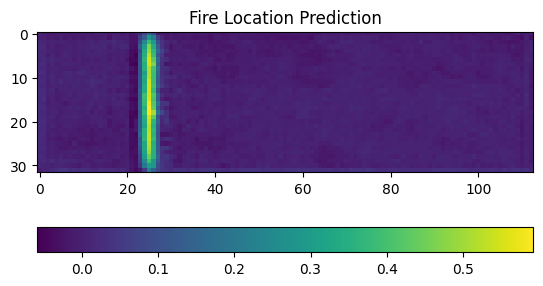

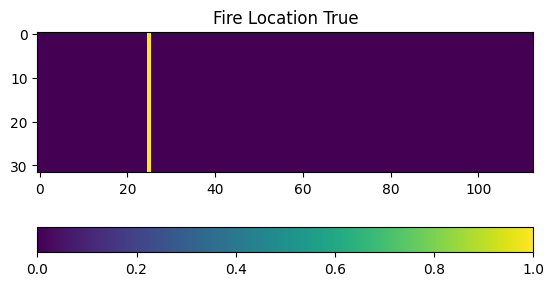

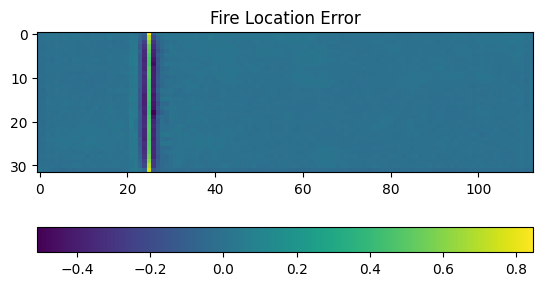

sample:  2


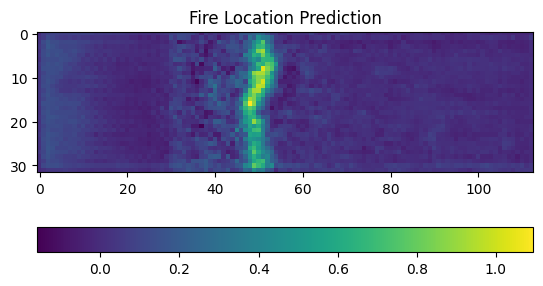

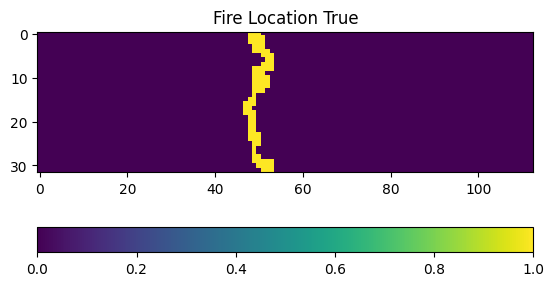

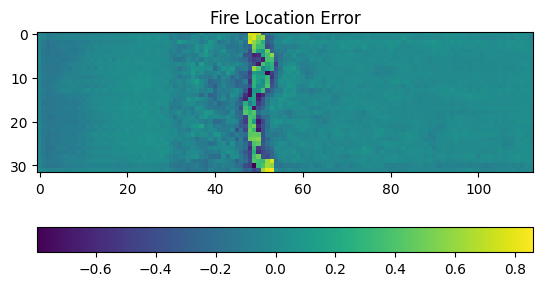

sample:  3


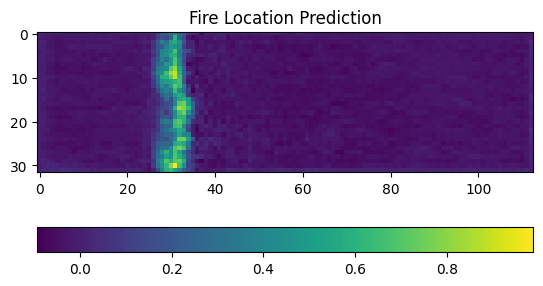

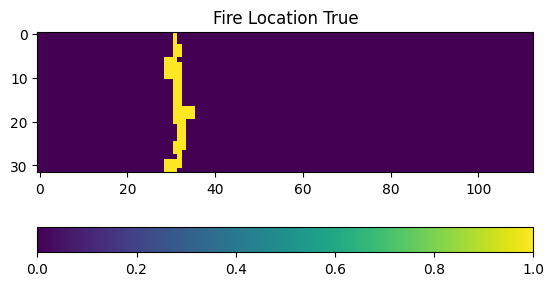

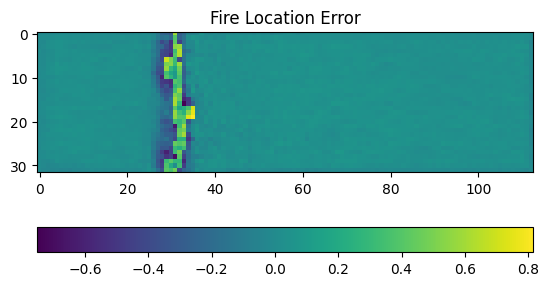

In [52]:
# Evaluate the model on the training and test sets
running_test_loss = 0.0
for xx,yy,tt  in test_loader:
    xx = xx.to(device)
    yy = yy.to(device)
    tt = tt.to(device)
    with torch.no_grad():
        outputs = model(xx, tt*0.)    
        test_loss = criterion(outputs, yy)
    running_test_loss += test_loss.item()
    
# Calculate the MSE test sets
test_mse = running_test_loss/len(test_loader)
print(f"Test MSE: {test_mse:.4f}")

# Plot predictions for a few samples from the test set
sample = 0
for xx,yy,tt  in test_loader:
    sample = sample + 1
    xx = xx.to(device)
    yy = yy.to(device)
    tt = tt.to(device)
    with torch.no_grad():
        outputs = model(xx, tt*0.)    
    
    fire_location_pred = outputs[0,0,2,:,:]
    fire_location_pred = fire_location_pred.detach().cpu().numpy()
    fire_location_true = yy[0,0,2,:,:]
    fire_location_true = fire_location_true.detach().cpu().numpy()
    print("sample: ", sample)
    plt.imshow(fire_location_pred.T)
    plt.colorbar(orientation='horizontal')
    plt.title("Fire Location Prediction")
    plt.show()
    plt.imshow(fire_location_true.T)
    plt.colorbar(orientation='horizontal')
    plt.title("Fire Location True")
    plt.show()
    err = (fire_location_true.T - fire_location_pred.T)
    plt.imshow(err)
    plt.colorbar(orientation='horizontal')
    plt.title("Fire Location Error")
    plt.show()
        
    if sample >= 5:
        break

# # Prepare submission file
# y_preds = {test_df['id'][idx]: pred_test_grid[idx][5:25].flatten(order='C').astype(np.float32) for idx in range(len(test_df))}

# df = pd.DataFrame.from_dict(y_preds, orient='index')
# df['id'] = df.index
# df = df.reset_index(drop=True)
# cols = ['id'] + df.columns.tolist()[:-1]
# df = df[cols]

# df.to_csv('submission.csv', index=False)

torch.Size([12, 1, 3, 113, 32])


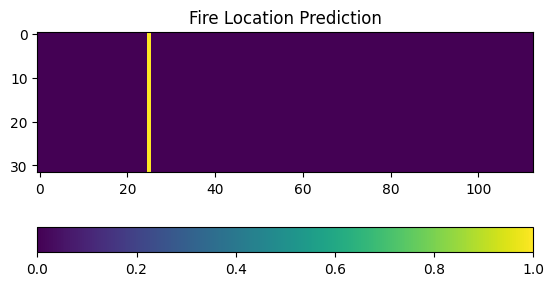

In [32]:
print(outputs.shape)
fire_location_pred = yy[0,0,2,:,:]
fire_location_pred = fire_location_pred.detach().cpu().numpy()
plt.imshow(fire_location_pred.T)
plt.colorbar(orientation='horizontal')
plt.title("Fire Location Prediction")
plt.show()

sample:  4


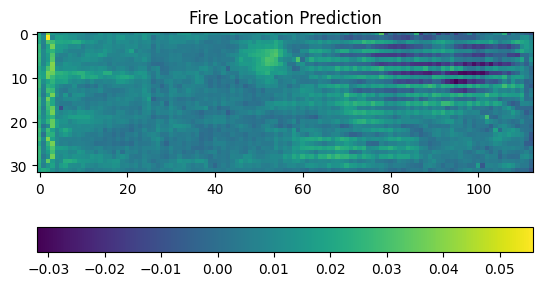

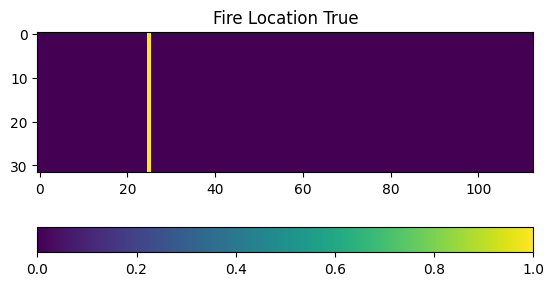

In [33]:
fire_location_pred = outputs[0,0,2,:,:]
fire_location_pred = fire_location_pred.detach().cpu().numpy()
fire_location_true = yy[0,0,2,:,:]
fire_location_true = fire_location_true.detach().cpu().numpy()
print("sample: ", sample)
plt.imshow(fire_location_pred.T)
plt.colorbar(orientation='horizontal')
plt.title("Fire Location Prediction")
plt.show()
plt.imshow(fire_location_true.T)
plt.colorbar(orientation='horizontal')
plt.title("Fire Location True")
plt.show()